Experiment E1-4:
- binary classification
- dataset train 3500, val 1500
- BATCH_SIZE = 20
- IMAGE_SIZE = 256
- EPOCHS = 20
- criterion = nn.BCEWithLogitsLoss()
- optimizer = SGD
- lr=1.0e-3

model:
- self.base_model(x)
- self.globalavg(x) # (4,4)
- self.flatten(x)
- self.fc(x)

In [1]:
import numpy as np
import os
import sys
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms, models
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from PIL import Image

In [2]:
# load common py
sys.path.append('../src')
import config
import common_utils
import data_utils
import train_utils
import plot_utils


In [3]:
# override config for experiment
EXP_CODE = "E1-4"
SAVE_FILENAME = f"stage1-{EXP_CODE}-metrics"

config.EPOCHS = 20
config.LEARNING_RATE = 1e-3

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

common_utils.set_seed(config.SEED)


In [5]:
df = pd.read_csv(config.TRAIN_CSV)

In [6]:
# split data into train, val, test 70/15/15
# for fast training, use only 3500 and 1500 samples for train and val

train_df, val_df, test_df, train_small_df, val_small_df = data_utils.split_data(df, config.SEED, small_train_size=3500, small_val_size=1500)

In [7]:
# create transforms
train_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [8]:
# create datasets
train_small_dataset = data_utils.SteelDataset(df=train_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=train_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                    )
val_small_dataset = data_utils.SteelDataset(df=val_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=test_val_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                   )


In [9]:
train_small_loader = DataLoader(train_small_dataset, batch_size=config.BATCH_SIZE,
                          shuffle=True,
                          num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                          )

val_small_loader = DataLoader(val_small_dataset, batch_size=config.BATCH_SIZE,
                         shuffle=False,
                         num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                         )


In [10]:
# create model
class SteelModel(nn.Module):
    def __init__(self):
        super(SteelModel, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1').features
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        #self.base_model.classifier = nn.Identity()

        self.globalavg = nn.AdaptiveAvgPool2d((4, 4))

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(20480, 1),
        )
               

    def forward(self, x):
        x = self.base_model(x)
        #print(x.shape)
        x = self.globalavg(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x 

In [11]:
model = SteelModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config.LEARNING_RATE)

In [12]:
%%time

arr_train_acc = []
arr_train_loss = []
arr_train_precision = []
arr_train_recall = []
arr_train_f1 = []
arr_train_rocauc = []
arr_train_conf_matrix = []

arr_val_acc = []
arr_val_loss = []
arr_val_precision = []
arr_val_recall = []
arr_val_f1 = []
arr_val_rocauc = []
arr_val_conf_matrix = []

idx = 0
for epoch in range(config.EPOCHS):
    train_loss, train_all_labels, train_all_preds, train_all_probs = train_utils.train_one_epoch(model, train_small_loader, criterion, optimizer, device)
    val_loss, val_all_labels, val_all_preds, val_all_probs = train_utils.validate_one_epoch(model, val_small_loader, criterion, device)

    # train metrics
    train_accuracy = (train_all_preds == train_all_labels).mean()
    train_precision = precision_score(train_all_labels, train_all_preds)
    train_recall = recall_score(train_all_labels, train_all_preds)
    train_f1 = f1_score(train_all_labels, train_all_preds)
    train_rocauc = roc_auc_score(train_all_labels, train_all_probs)
    train_conf_matrix = confusion_matrix(train_all_labels, train_all_preds)
    train_tn, train_fp, train_fn, train_tp = train_conf_matrix.ravel()
    
    arr_train_loss.append(train_loss)
    arr_train_acc.append(train_accuracy)
    arr_train_precision.append(train_precision)
    arr_train_recall.append(train_recall)
    arr_train_f1.append(train_f1)
    arr_train_rocauc.append(train_rocauc)
    arr_train_conf_matrix.append({'tn': train_tn, 'fp': train_fp, 'fn': train_fn, 'tp': train_tp})

    # val metrics
    val_accuracy = (val_all_preds == val_all_labels).mean()
    val_precision = precision_score(val_all_labels, val_all_preds)
    val_recall = recall_score(val_all_labels, val_all_preds)
    val_f1 = f1_score(val_all_labels, val_all_preds)
    val_rocauc = roc_auc_score(val_all_labels, val_all_probs)
    val_conf_matrix = confusion_matrix(val_all_labels, val_all_preds)
    val_tn, val_fp, val_fn, val_tp = val_conf_matrix.ravel()

    arr_val_loss.append(val_loss)
    arr_val_acc.append(val_accuracy)
    arr_val_precision.append(val_precision)
    arr_val_recall.append(val_recall)
    arr_val_f1.append(val_f1)
    arr_val_rocauc.append(val_rocauc)
    arr_val_conf_matrix.append({'tn': val_tn, 'fp': val_fp, 'fn': val_fn, 'tp': val_tp})

    print(idx+1)
    print(f"Epoch {epoch+1}/{config.EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    print(f"  Train Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f} | ROC AUC: {train_rocauc:.4f}")
    print(f"  Train Confusion Matrix: TN={train_tn}, FP={train_fp}, FN={train_fn}, TP={train_tp}")
    print(f"  Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f} | ROC AUC: {val_rocauc:.4f}")
    print(f"  Val Confusion Matrix: TN={val_tn}, FP={val_fp}, FN={val_fn}, TP={val_tp}")

    idx += 1
    #break


1
Epoch 1/20
  Train Loss: 0.4753 | Train Acc: 0.7597
  Val Loss  : 0.3663 | Val Acc: 0.8380
  Train Precision: 0.7662 | Recall: 0.8059 | F1: 0.7855 | ROC AUC: 0.8493
  Train Confusion Matrix: TN=1119, FP=470, FN=371, TP=1540
  Val Precision: 0.8165 | Recall: 0.9072 | F1: 0.8595 | ROC AUC: 0.9241
  Val Confusion Matrix: TN=514, FP=167, FN=76, TP=743
2
Epoch 2/20
  Train Loss: 0.3407 | Train Acc: 0.8491
  Val Loss  : 0.3306 | Val Acc: 0.8567
  Train Precision: 0.8484 | Recall: 0.8812 | F1: 0.8645 | ROC AUC: 0.9320
  Train Confusion Matrix: TN=1288, FP=301, FN=227, TP=1684
  Val Precision: 0.8872 | Recall: 0.8449 | F1: 0.8655 | ROC AUC: 0.9341
  Val Confusion Matrix: TN=593, FP=88, FN=127, TP=692
3
Epoch 3/20
  Train Loss: 0.2915 | Train Acc: 0.8820
  Val Loss  : 0.3186 | Val Acc: 0.8660
  Train Precision: 0.8802 | Recall: 0.9074 | F1: 0.8936 | ROC AUC: 0.9520
  Train Confusion Matrix: TN=1353, FP=236, FN=177, TP=1734
  Val Precision: 0.8433 | Recall: 0.9267 | F1: 0.8831 | ROC AUC: 0.940

In [13]:
df_metrics = train_utils.build_metric_df(
    arr_train_loss, arr_train_acc, arr_train_precision, arr_train_recall, 
    arr_train_f1, arr_train_rocauc, arr_train_conf_matrix,
    arr_val_loss, arr_val_acc, arr_val_precision, arr_val_recall, 
    arr_val_f1, arr_val_rocauc, arr_val_conf_matrix
)


In [14]:
df_metrics

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,train_conf_matrix,val_loss,val_acc,val_precision,...,val_rocauc,val_conf_matrix,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
0,0.475344,0.759714,0.766169,0.805861,0.785514,0.849316,"{'tn': 1119, 'fp': 470, 'fn': 371, 'tp': 1540}",0.366330,0.838000,0.816484,...,0.924108,"{'tn': 514, 'fp': 167, 'fn': 76, 'tp': 743}",1119,470,371,1540,514,167,76,743
1,0.340662,0.849143,0.848363,0.881214,0.864476,0.932031,"{'tn': 1288, 'fp': 301, 'fn': 227, 'tp': 1684}",0.330594,0.856667,0.887179,...,0.934078,"{'tn': 593, 'fp': 88, 'fn': 127, 'tp': 692}",1288,301,227,1684,593,88,127,692
2,0.291495,0.882000,0.880203,0.907378,0.893584,0.951970,"{'tn': 1353, 'fp': 236, 'fn': 177, 'tp': 1734}",0.318614,0.866000,0.843333,...,0.940763,"{'tn': 540, 'fp': 141, 'fn': 60, 'tp': 759}",1353,236,177,1734,540,141,60,759
3,0.258811,0.900857,0.901437,0.918891,0.910080,0.962994,"{'tn': 1397, 'fp': 192, 'fn': 155, 'tp': 1756}",0.303674,0.874667,0.876043,...,0.943893,"{'tn': 577, 'fp': 104, 'fn': 84, 'tp': 735}",1397,192,155,1756,577,104,84,735
4,0.243660,0.911143,0.914079,0.924123,0.919074,0.967401,"{'tn': 1423, 'fp': 166, 'fn': 145, 'tp': 1766}",0.312018,0.860667,0.915531,...,0.945731,"{'tn': 619, 'fp': 62, 'fn': 147, 'tp': 672}",1423,166,145,1766,619,62,147,672
5,0.234518,0.909143,0.912481,0.922030,0.917231,0.969468,"{'tn': 1420, 'fp': 169, 'fn': 149, 'tp': 1762}",0.295446,0.878667,0.892725,...,0.945846,"{'tn': 594, 'fp': 87, 'fn': 95, 'tp': 724}",1420,169,149,1762,594,87,95,724
6,0.220570,0.913714,0.918357,0.924123,0.921231,0.973501,"{'tn': 1432, 'fp': 157, 'fn': 145, 'tp': 1766}",0.296583,0.872667,0.909922,...,0.948815,"{'tn': 612, 'fp': 69, 'fn': 122, 'tp': 697}",1432,157,145,1766,612,69,122,697
7,0.205280,0.923429,0.927197,0.933019,0.930099,0.977945,"{'tn': 1449, 'fp': 140, 'fn': 128, 'tp': 1783}",0.291008,0.877333,0.888617,...,0.947635,"{'tn': 590, 'fp': 91, 'fn': 93, 'tp': 726}",1449,140,128,1783,590,91,93,726
8,0.203929,0.926571,0.928497,0.937729,0.933090,0.977689,"{'tn': 1451, 'fp': 138, 'fn': 119, 'tp': 1792}",0.292216,0.878667,0.905732,...,0.948851,"{'tn': 607, 'fp': 74, 'fn': 108, 'tp': 711}",1451,138,119,1792,607,74,108,711
9,0.183638,0.936857,0.938733,0.946102,0.942403,0.983372,"{'tn': 1471, 'fp': 118, 'fn': 103, 'tp': 1808}",0.290311,0.882000,0.865604,...,0.950292,"{'tn': 563, 'fp': 118, 'fn': 59, 'tp': 760}",1471,118,103,1808,563,118,59,760


In [15]:
print('Val Metrics:')
print(df_metrics[config.VAL_METRICS])
print('')
print('Val Confusion Matrix:')
print(df_metrics[config.VAL_CF])

Val Metrics:
    val_loss   val_acc  val_precision  val_recall    val_f1  val_rocauc
0   0.366330  0.838000       0.816484    0.907204  0.859456    0.924108
1   0.330594  0.856667       0.887179    0.844933  0.865541    0.934078
2   0.318614  0.866000       0.843333    0.926740  0.883072    0.940763
3   0.303674  0.874667       0.876043    0.897436  0.886610    0.943893
4   0.312018  0.860667       0.915531    0.820513  0.865422    0.945731
5   0.295446  0.878667       0.892725    0.884005  0.888344    0.945846
6   0.296583  0.872667       0.909922    0.851038  0.879495    0.948815
7   0.291008  0.877333       0.888617    0.886447  0.887531    0.947635
8   0.292216  0.878667       0.905732    0.868132  0.886534    0.948851
9   0.290311  0.882000       0.865604    0.927961  0.895698    0.950292
10  0.296862  0.870667       0.909567    0.847375  0.877370    0.949767
11  0.286913  0.880667       0.906091    0.871795  0.888612    0.949908
12  0.280407  0.883333       0.878824    0.912088  

In [16]:
df_metrics.describe()

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,val_loss,val_acc,val_precision,val_recall,val_f1,val_rocauc,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.00000,20.00000,20.00000,20.000000,20.000000
mean,0.212201,0.918743,0.919984,0.932836,0.926337,0.971303,0.297562,0.874400,0.887336,0.883455,0.884755,0.946807,1432.950000,156.050000,128.35000,1782.65000,588.05000,92.95000,95.450000,723.550000
std,0.081914,0.046209,0.045177,0.036923,0.041087,0.032450,0.021024,0.011511,0.023956,0.028264,0.010491,0.006902,91.533414,91.533414,70.56037,70.56037,25.50227,25.50227,23.148207,23.148207
min,0.142361,0.759714,0.766169,0.805861,0.785514,0.849316,0.277499,0.838000,0.816484,0.820513,0.859456,0.924108,1119.000000,84.000000,64.00000,1540.00000,514.00000,62.00000,59.000000,672.000000
25%,0.157758,0.910643,0.913679,0.923600,0.918613,0.968951,0.286303,0.872167,0.878128,0.869963,0.882177,0.945817,1422.250000,102.750000,86.00000,1765.00000,577.75000,76.25000,79.750000,712.500000
50%,0.184100,0.935143,0.934693,0.944532,0.941006,0.982953,0.290660,0.878333,0.891618,0.885226,0.887070,0.948975,1462.500000,126.500000,106.00000,1805.00000,593.50000,87.50000,94.000000,725.000000
75%,0.236804,0.946071,0.946700,0.954997,0.950830,0.988530,0.298565,0.881500,0.903332,0.902625,0.892456,0.950503,1486.250000,166.750000,146.00000,1825.00000,604.75000,103.25000,106.500000,739.250000
max,0.475344,0.956000,0.956364,0.966510,0.959938,0.991202,0.366330,0.885333,0.915531,0.927961,0.895698,0.952467,1505.000000,470.000000,371.00000,1847.00000,619.00000,167.00000,147.000000,760.000000


In [17]:
print(df_metrics.describe())

       train_loss  train_acc  train_precision  train_recall   train_f1  \
count   20.000000  20.000000        20.000000     20.000000  20.000000   
mean     0.212201   0.918743         0.919984      0.932836   0.926337   
std      0.081914   0.046209         0.045177      0.036923   0.041087   
min      0.142361   0.759714         0.766169      0.805861   0.785514   
25%      0.157758   0.910643         0.913679      0.923600   0.918613   
50%      0.184100   0.935143         0.934693      0.944532   0.941006   
75%      0.236804   0.946071         0.946700      0.954997   0.950830   
max      0.475344   0.956000         0.956364      0.966510   0.959938   

       train_rocauc   val_loss    val_acc  val_precision  val_recall  \
count     20.000000  20.000000  20.000000      20.000000   20.000000   
mean       0.971303   0.297562   0.874400       0.887336    0.883455   
std        0.032450   0.021024   0.011511       0.023956    0.028264   
min        0.849316   0.277499   0.838000    

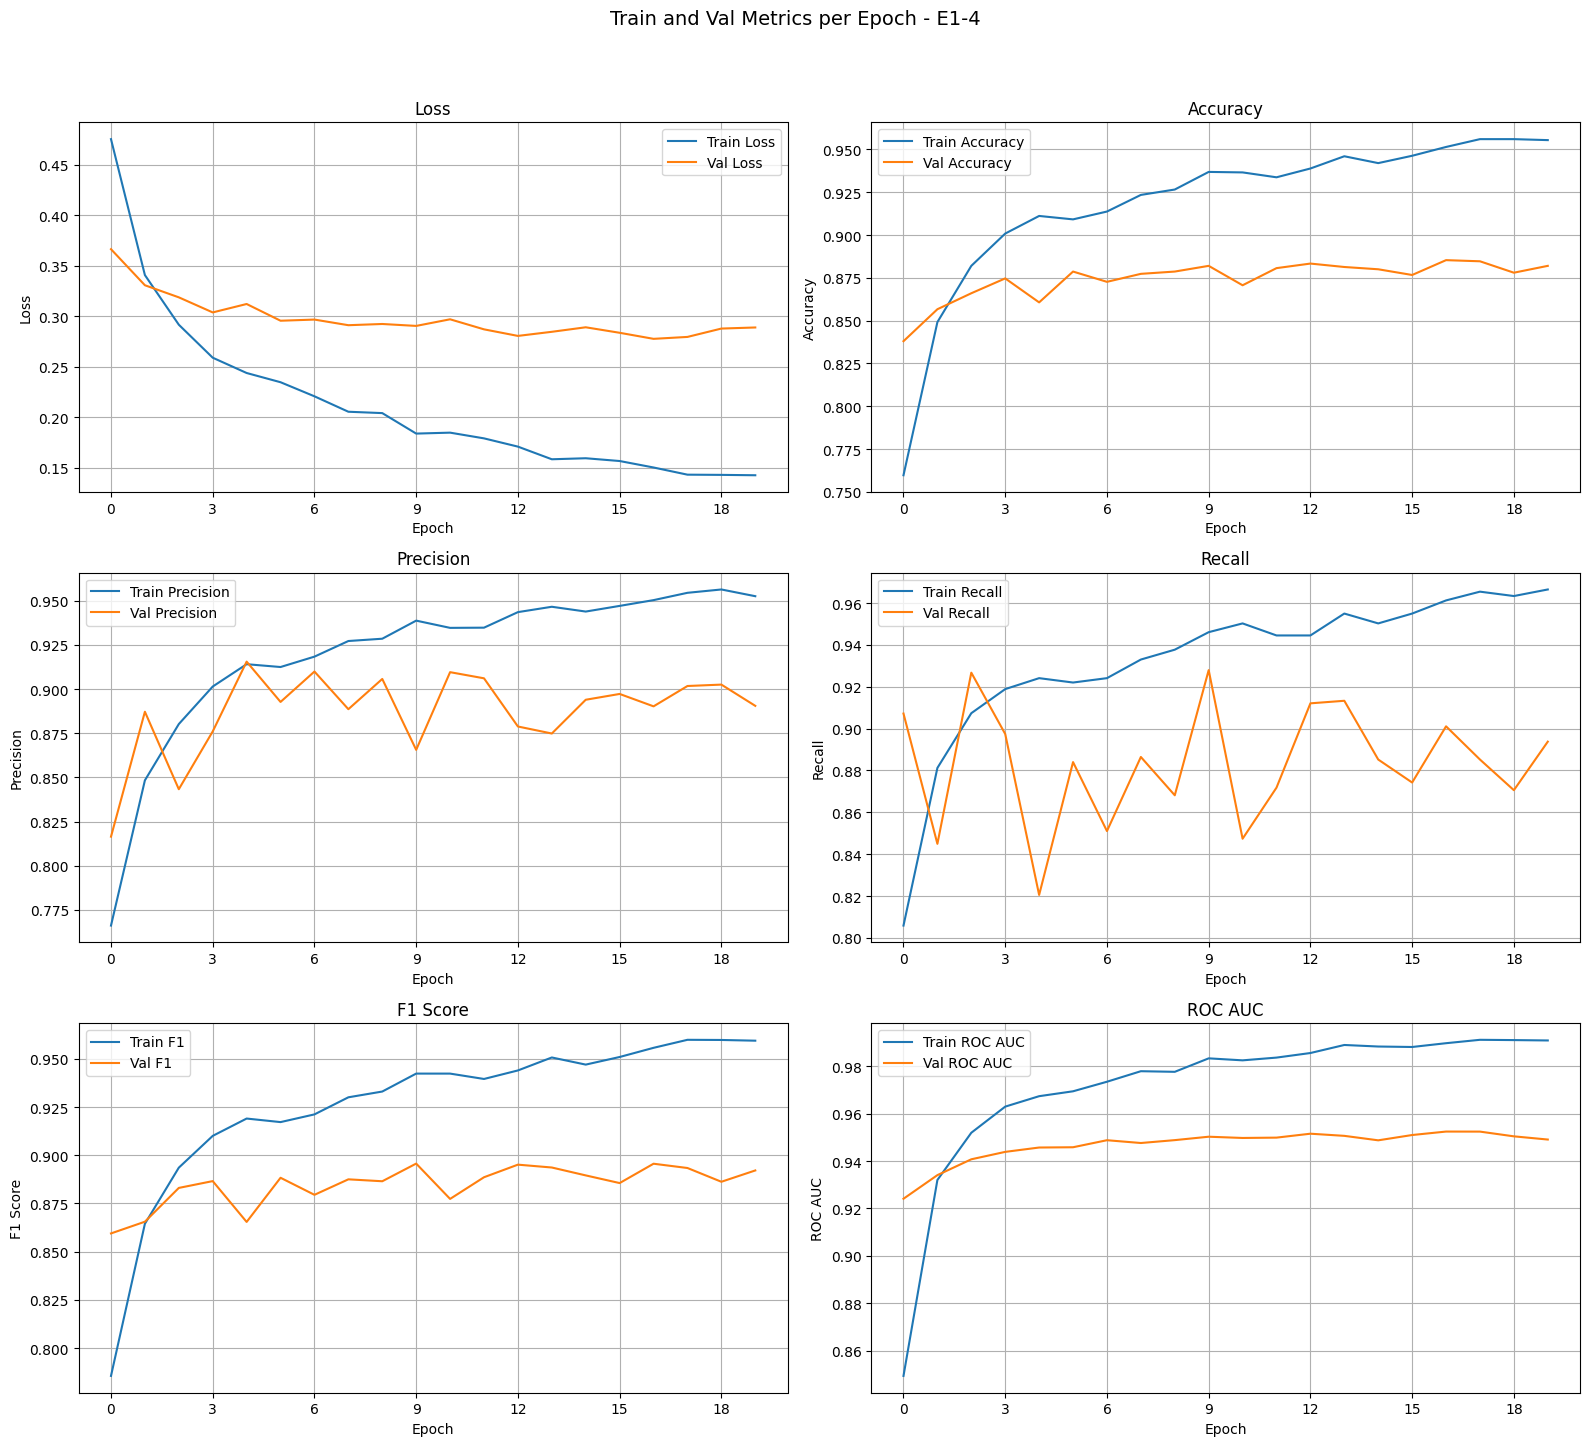

In [18]:
plot_utils.plot_train_val_metrics(df_metrics, exp_code=EXP_CODE, save_path=SAVE_FILENAME+".png")

In [19]:
df_train_conf_matrix = df_metrics['train_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
df_val_conf_matrix = df_metrics['val_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
#df_metrics[['val_tn', 'val_fp', 'val_fn', 'val_tp']]
df_train_conf_matrix.columns = ['train_tn', 'train_fp', 'train_fn', 'train_tp']
df_val_conf_matrix.columns = ['val_tn', 'val_fp', 'val_fn', 'val_tp']



In [20]:
df_train_conf_matrix.describe()

,train_tn,train_fp,train_fn,train_tp
count,20.000000,20.000000,20.00000,20.00000
mean,1432.950000,156.050000,128.35000,1782.65000
std,91.533414,91.533414,70.56037,70.56037
min,1119.000000,84.000000,64.00000,1540.00000
25%,1422.250000,102.750000,86.00000,1765.00000
50%,1462.500000,126.500000,106.00000,1805.00000
75%,1486.250000,166.750000,146.00000,1825.00000
max,1505.000000,470.000000,371.00000,1847.00000


In [21]:
df_val_conf_matrix.describe()

,val_tn,val_fp,val_fn,val_tp
count,20.00000,20.00000,20.000000,20.000000
mean,588.05000,92.95000,95.450000,723.550000
std,25.50227,25.50227,23.148207,23.148207
min,514.00000,62.00000,59.000000,672.000000
25%,577.75000,76.25000,79.750000,712.500000
50%,593.50000,87.50000,94.000000,725.000000
75%,604.75000,103.25000,106.500000,739.250000
max,619.00000,167.00000,147.000000,760.000000


In [22]:
df_metrics.to_csv(SAVE_FILENAME+".csv", index=False)